## Figure 6

Code to reproduce Figure 6 - Zonal mean SAOD and TOC plots for UKESM1.1, GloSSAC, and Bodeker data.

Data used:
- UKESM1.1 simulations with 1991 pinatubo eruption - SAOD and TOC
    - filenames: pinatubo_monthly_toc.nc, pinatubo_control_monthly_toc.nc, pinatubo_monthly_saod.nc, pinatubo_control_monthly_saod.nc
- GloSSAC v.2.22 data
    - filename: GloSSAC_V2.22.nc
- Bodeker v3.5.2 data
    - filenames: BSFilledTCO_V3.5.2_*_Monthly.nc

## Import packages

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os
from matplotlib.colors import LogNorm

In [12]:
def calc_saod(df):
    aitken_soluble = df.m01s02i251[:,2,:,:]
    accum_soluble = df.m01s02i252[:,2,:,:]
    coarse_soluble = df.m01s02i253[:,2,:,:]    
    aitken_insoluble = df.m01s02i254[:,2,:,:]
    
    SAOD_sum = aitken_soluble + accum_soluble + coarse_soluble + aitken_insoluble# + accum_insoluble + coarse_insoluble
    
    weights = np.cos(np.deg2rad(SAOD_sum.latitude))
    weights.name = "weights"
    
    SAOD_sum_weighted = SAOD_sum.weighted(weights)

    SAOD_zonalmean = SAOD_sum_weighted.mean("longitude")

    SAOD_globalmean = SAOD_sum_weighted.mean(("longitude", "latitude"))    

    return SAOD_zonalmean, SAOD_globalmean

def calc_toc(df):

    weights = np.cos(np.deg2rad(df.latitude))
    weights.name = "weights"
    
    sum_weighted = df.weighted(weights)

    zonalmean = sum_weighted.mean("longitude")

    globalmean = sum_weighted.mean(("longitude", "latitude"))    

    return zonalmean


def calc_antarc_toc(df):

    df = df[:,0:24,:]
    weights = np.cos(np.deg2rad(df.latitude))
    weights.name = "weights"
    
    sum_weighted = df.weighted(weights)

    zonalmean = sum_weighted.mean("longitude")

    globalmean = sum_weighted.mean(("longitude", "latitude"))    

    return globalmean

## Read files

In [19]:
os.chdir('/gws/nopw/j04/vplume/mchim/netcdf_files/Pinatubo_HIST')

# Load UKESM run data
hist_ozone = {}
hist_ozone['pinatubo'] = xr.open_dataset('pinatubo_monthly_toc.nc')
hist_ozone['control'] = xr.open_dataset('pinatubo_control_monthly_toc.nc')

hist_saod = {}
hist_saod['pinatubo'] = xr.open_dataset('pinatubo_monthly_saod.nc')
hist_saod['control'] = xr.open_dataset('pinatubo_control_monthly_saod.nc')

## Load GloSSAC
glossac = xr.open_dataset('/home/users/mmc70/Notebooks/Ozone_analysis/Glossac/GloSSAC_V2.22.nc')

# Load Bodeker datasets
base_path = '/home/users/mmc70/Notebooks/Ozone_analysis/Bodeker/'
file_pattern = 'BSFilledTCO_V3.5.2_{}_Monthly.nc'

years = range(1979, 1994)
datasets = []
zonal_means = []

for year in years:
    filepath = base_path + file_pattern.format(year)
    dataset = xr.open_dataset(filepath)
    datasets.append(dataset)
    
    zonal_mean = calc_toc(dataset.tco)
    zonal_means.append(zonal_mean)

# Create the control dataset (1979-1990)
BD_zonal_control = xr.concat(zonal_means[:12], dim='time')  # First 12 years (1979-1990)

# Create the main dataset (1991-1993)
BD_zonal = xr.concat(zonal_means[12:], dim='time')  # Last 3 years (1991-1993)

BD_zonal_control_gb = BD_zonal_control.groupby('time.month').mean('time')

## Plots

In [11]:
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['legend.edgecolor']='black'
plt.rcParams['axes.linewidth']='0.8'
plt.rcParams['xtick.bottom']= 'True'
plt.rcParams['ytick.left']= 'True'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['xtick.major.size']='3.5'
plt.rcParams['ytick.major.size']='3.5'
plt.rcParams['xtick.major.width']='0.8'
plt.rcParams['ytick.major.width']='0.8'

plt.rc('font', size=16)          # controls default text sizes          
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title

In [13]:
ens_saod = hist_saod['pinatubo'].mean(dim='ensemble')
ens_control_saod = hist_saod['control'].mean(dim='ensemble')

zonal_saod, global_saod = calc_saod(ens_saod)
zonal_control_saod, global_control_saod = calc_saod(ens_control_saod)

In [14]:
# Slice 1991 to 1994, 525nm
sliced_glossac = glossac.Glossac_Aerosol_Optical_Depth[144:144+12*3,:,2]

sliced_glossac = sliced_glossac.fillna(0)
time_coords = pd.to_datetime(sliced_glossac.time.values, format='%Y%m')
sliced_glossac = sliced_glossac.assign_coords(time=time_coords)
weights = np.cos(np.deg2rad(sliced_glossac.lat))
weights.name = "weights"
SAOD_weighted = sliced_glossac.weighted(weights)
glossac_mean = SAOD_weighted.mean("lat")
glossac_zonal_mean = SAOD_weighted.mean("time")

# 1979-1990 mean as control
sliced_glossac_control = glossac.Glossac_Aerosol_Optical_Depth[:144,:,2]

# change the time array to datetime coordinates for groupby
data_array = sliced_glossac_control.fillna(0)
time_coords = pd.to_datetime(data_array.time.values, format='%Y%m')
data_array = data_array.assign_coords(time=time_coords)

zonal_glossac_control = data_array.groupby('time.month').mean('time')
weights = np.cos(np.deg2rad(zonal_glossac_control.lat))
weights.name = "weights"
SAOD_weighted = zonal_glossac_control.weighted(weights)
glossac_control_global_mean = SAOD_weighted.mean(dim=["lat"])

In [15]:
ens_toc = hist_ozone['pinatubo'].m01s50i219.mean(dim='ensemble')
ens_control_toc = hist_ozone['control'].m01s50i219.mean(dim='ensemble')

zonal_toc = calc_toc(ens_toc)
antarc_toc = calc_antarc_toc(ens_toc)

zonal_control_toc = calc_toc(ens_control_toc)
antarc_control_toc = calc_antarc_toc(ens_control_toc)

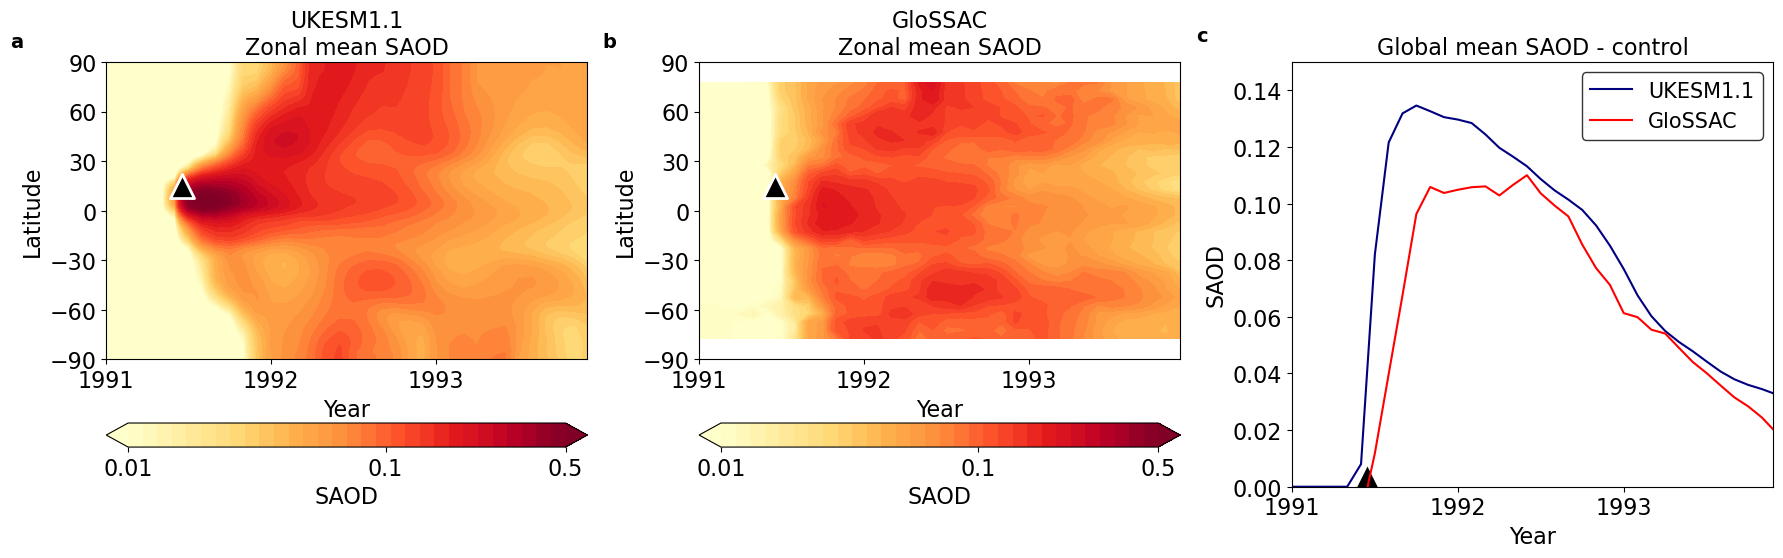

In [16]:
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: UKESM1.1
ax1 = axes1[0]
ax1.text(-0.2, 1.05, 'a', transform=ax1.transAxes, fontsize=14, fontweight='bold')

latitudes = zonal_toc.latitude
time = np.arange(1991,1994,1/12)
X, Y = np.meshgrid(time, latitudes)

levels = np.logspace(np.log10(0.01), np.log10(0.5), 31)

contour1 = ax1.contourf(X, Y, zonal_saod.transpose(), levels=levels, cmap='YlOrRd', extend='both',
                       norm=LogNorm(vmin=0.01, vmax=0.5))
ax1.scatter(1991+165/360, 15, marker='^', color='k', s=300, ec='white',lw=2)

cbar1 = plt.colorbar(contour1, ax=ax1, label='SAOD', orientation='horizontal', pad=0.15)
cbar1.set_ticks([0.01, 0.1, 0.5])
cbar1.set_ticklabels(['0.01', '0.1', '0.5'])

ax1.set_title('UKESM1.1\nZonal mean SAOD')
ax1.set_xlabel('Year')
ax1.set_yticks(np.arange(-90, 91, 30))
ax1.set_ylabel('Latitude')
ax1.set_xticks([1991, 1992, 1993])


# Plot 2: ML-TOMCAT
ax2 = axes1[1]
ax2.text(-0.2, 1.05, 'b', transform=ax2.transAxes, fontsize=14, fontweight='bold')
latitudes = sliced_glossac.lat
time = np.arange(1991,1994,1/12)
X, Y = np.meshgrid(time, latitudes)

levels = np.logspace(np.log10(0.01), np.log10(0.5), 31)

contour2 = ax2.contourf(X, Y, sliced_glossac.transpose(), levels=levels, cmap='YlOrRd', extend='both',
                       norm=LogNorm(vmin=0.01, vmax=0.5))
ax2.scatter(1991+165/360, 15, marker='^', color='k', s=300, ec='white',lw=2)

cbar2 = plt.colorbar(contour2, ax=ax2, label='SAOD', orientation='horizontal', pad=0.15)
cbar2.set_ticks([0.01, 0.1, 0.5])
cbar2.set_ticklabels(['0.01', '0.1', '0.5'])

ax2.set_title('GloSSAC\nZonal mean SAOD')
ax2.set_xlabel('Year')
ax2.set_yticks(np.arange(-90, 91, 30))
ax2.set_ylabel('Latitude')
ax2.set_xticks([1991, 1992, 1993])


# Plot 3: SAOD time series
ax3 = axes1[2]
ax3.text(-0.2, 1.05, 'c', transform=ax3.transAxes, fontsize=14, fontweight='bold')
time = np.arange(1991,1994,1/12)

ax3.plot(time, global_saod - global_control_saod, label='UKESM1.1', color = 'navy')
ax3.plot(time, glossac_mean.groupby('time.month') - glossac_control_global_mean, label='GloSSAC', color = 'red')
ax3.scatter(1991.45,0, color='k', ec = 'white', marker='^', s=1200, lw=2)

ax3.set_title('Global mean SAOD - control')
ax3.set_xlabel('Year')
ax3.set_xticks([1991, 1992, 1993])
ax3.set_ylabel('SAOD')
ax3.set_ylim(0,0.15)
ax3.set_xlim(1991,1993.9)
ax3.legend(fontsize = 15)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

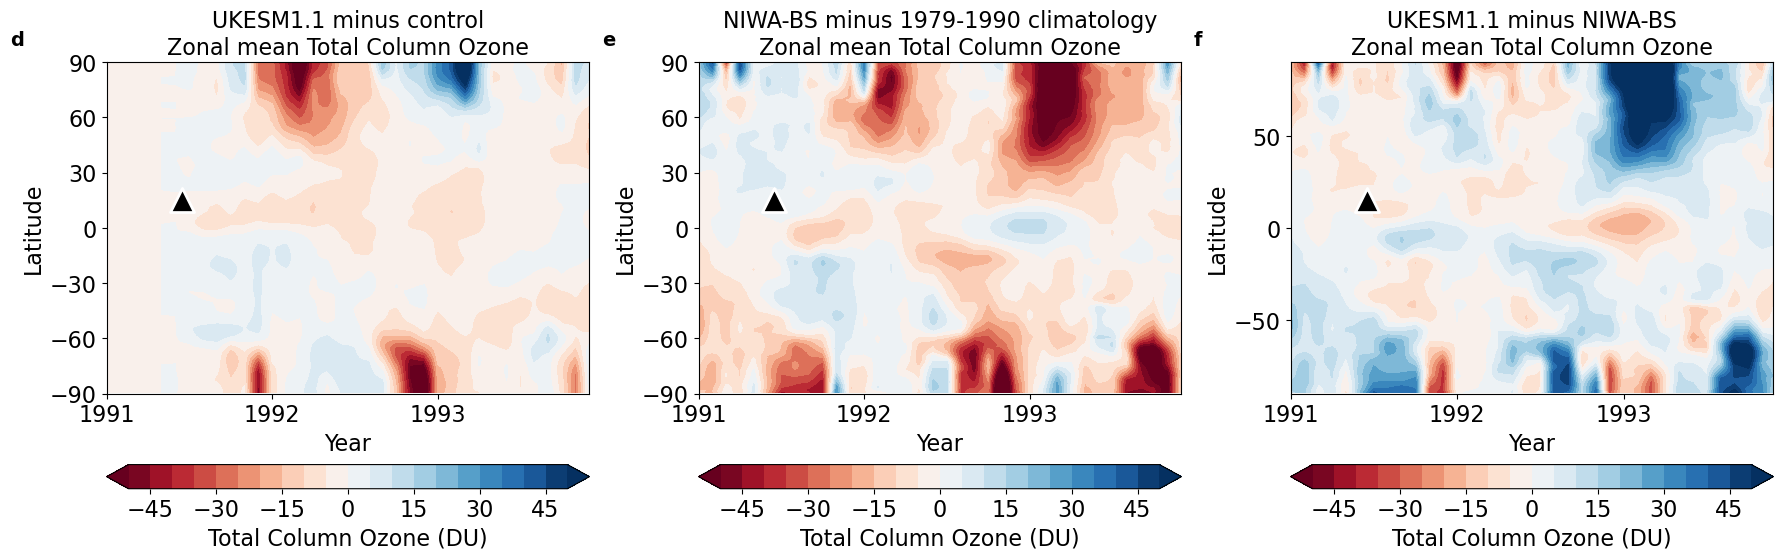

In [17]:
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: UKESM1.1
ax1 = axes1[0]
ax1.text(-0.2, 1.05, 'd', transform=ax1.transAxes, fontsize=14, fontweight='bold')

latitudes = zonal_toc.latitude
time = np.arange(1991,1994,1/12)
X,Y = np.meshgrid(time, latitudes)

levels = np.linspace(-50, 50, 21)

diff = zonal_toc - zonal_control_toc

contour1 = ax1.contourf(X, Y, diff.transpose(), levels=levels, cmap='RdBu', extend='both')
ax1.scatter(1991+165/360, 15, marker='^', color='k', s=300, ec='white',lw=2)

cbar1 = plt.colorbar(contour1, ax=ax1, label='Total Column Ozone (DU)', orientation='horizontal', pad=0.15)

ax1.set_title('UKESM1.1 minus control\nZonal mean Total Column Ozone')
ax1.set_xlabel('Year')
ax1.set_yticks(np.arange(-90, 91, 30))
ax1.set_ylabel('Latitude')
ax1.set_xticks([1991, 1992, 1993])


# Plot 2: ML-TOMCAT
ax2 = axes1[1]
ax2.text(-0.2, 1.05, 'e', transform=ax2.transAxes, fontsize=14, fontweight='bold')
latitudes = BD_zonal.latitude
time = np.arange(1991,1994,1/12)
X,Y = np.meshgrid(time, latitudes)

levels = np.linspace(-50, 50, 21)

diff = BD_zonal.groupby('time.month') - BD_zonal_control_gb

contour2 = ax2.contourf(X, Y, diff.transpose(), levels=levels, cmap='RdBu', extend='both')
ax2.scatter(1991+165/360, 15, marker='^', color='k', s=300, ec='white',lw=2)

#ax2.axvline(1991+9/12, color = 'k')

cbar2 = plt.colorbar(contour2, ax=ax2, label='Total Column Ozone (DU)', orientation='horizontal', pad=0.15)
ax2.set_title('NIWA-BS minus 1979-1990 climatology\nZonal mean Total Column Ozone')
ax2.set_xlabel('Year')
ax2.set_yticks(np.arange(-90, 91, 30))
ax2.set_ylabel('Latitude')
ax2.set_xticks([1991, 1992, 1993])

# Plot 3: UKESM1.1 - Bodeker
# Match the time dimension of the two datasets

BD_time = BD_zonal.time
zonal_toc['time'] = BD_time
zonal_control_toc['time'] = BD_time

diff_toc = zonal_toc - zonal_control_toc
diff_BD = BD_zonal.groupby('time.month') - BD_zonal_control_gb


target_lat = zonal_toc.latitude
target_time = zonal_toc.time

# Interpolate both datasets
interpolated_data1 = diff_toc.interp(**{'latitude': target_lat, 
                                         'time': target_time})

interpolated_data2 = diff_BD.interp(**{'latitude': target_lat, 
                                         'time': target_time})
    
# Calculate difference
difference = interpolated_data1 - interpolated_data2
difference

ax3 = axes1[2]
ax3.text(-0.2, 1.05, 'f', transform=ax3.transAxes, fontsize=14, fontweight='bold')
latitudes = zonal_toc.latitude
time = np.arange(1991,1994,1/12)
X,Y = np.meshgrid(time, latitudes)

levels = np.linspace(-50, 50, 21)

contour3 = ax3.contourf(X, Y, difference.transpose(), levels=levels, cmap='RdBu', extend = 'both')
ax3.scatter(1991+165/360, 15, marker='^', color = 'k', s = 300, ec = 'white', lw=2)
cbar3 = plt.colorbar(contour3, ax=ax3, label='Total Column Ozone (DU)', orientation='horizontal', pad=0.15)

#ax3.axvline(1991+9/12, color = 'k')
#ax3.axvline(1992+9/12, color = 'k')

ax3.set_title('UKESM1.1 minus NIWA-BS\nZonal mean Total Column Ozone')
ax3.set_xlabel('Year')
ax3.set_xticks([1991, 1992, 1993])
ax3.set_ylabel('Latitude')
ax3.set_ylim(-90,90)
ax3.set_xlim(1991,1993.9)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()